In [1]:
import snap
import random as rd
import numpy as np
from dataclasses import dataclass, field
import queue
from numpy.linalg import inv
import numpy.linalg as lg
import matplotlib.pyplot as plt
import copy
import time
from tqdm.notebook import trange, tqdm

#G5 = snap.LoadEdgeList(snap.TUNGraph, "com-orkut.ungraph.txt", 0, 1)
#N_G = G5.GetNodes()

# All the functions to compute various estimators of Katz centrality

In [11]:
def extract_subgraph(n): # extract a subgrpah of n points from G
    D = {}
    while len(D)<n:
        D[rd.randint(0,N_G)]=1
    L = [key for key in D]
    #print(D)
    #print(L)
    return L

def aux(G,n):
    D={}
    Q = queue.Queue()
    x = rd.randint(0,N_G)
    D[x]=1
    Q.put(x)
    while len(D)<n:
        x = Q.get()
        for e in G.GetNI(x).GetOutEdges():
            if len(D)>n:
                break
            if not e in D:
                D[e]=1
                Q.put(e)
    L = [key for key in D]
    return L

def extract_subgraph2(G,N):
    n= 2*N
    while n>1.2*N:
        L = aux(G,N)
        n = len(L)
    return L

def node_convertor(G):
    n = len(list(G.Nodes()))
    L = [0]*n
    D = {}
    i = 0
    for N in G.Nodes():
        L[i] = N.GetId()
        D[N.GetId()] = i
        i+=1
    return L,D

def matrix_convertor(G,D):
    n = len(list(G.Nodes()))
    A = np.zeros((n,n))
    for e in G.Edges():
        i = D[e.GetSrcNId()]
        j = D[e.GetDstNId()]
        A[i,j] = 1
    return A

def matrix_convertor_un(G,D):
    n = len(list(G.Nodes()))
    A = np.zeros((n,n))
    for e in G.Edges():
        i = D[e.GetSrcNId()]
        j = D[e.GetDstNId()]
        A[i,j] = 1
        A[j,i] = 1
    return A

def katz_matrix(A,alpha,Eig=False):  
    n,_ = A.shape
    if Eig:
        v,_ = lg.eig(A)
        V = []
        for i in range(n):
            V.append(v[i])
        V.sort()
        print(1/abs(V[-1]))
    
    I = np.eye(n)
    J = np.ones(n)
    return ((inv((I-alpha*A))-I)@J)

def loss_bias_error(real_katz,noisy_katz,n):
    E = 0
    B = 0
    R = 0
    for i in range(n):
        E+=(real_katz[i]-noisy_katz[i])**2/n
        B+=(real_katz[i]-noisy_katz[i])/n
        R+=abs(real_katz[i]-noisy_katz[i])/(max(n*real_katz[i],1e4))
    return E,B,R

def make_subgraph(G,N):
    L = extract_subgraph(N)
    return G.GetSubGraph(L)
    
def make_subgraph2(G,N):
    L = extract_subgraph2(G,N)
    return G.GetSubGraph(L)

def plot_several_round(G,Eps,alpha,count = 40, extract=False,N=1000):
    if extract:
        n=2*N
        while n>1.2*N:
            L = extract_subgraph2(G,N)
            G1 = G.GetSubGraph(L)
            n = len(list(G1.Nodes()))
    else:
        G1=G
        n = len(list(G1.Nodes()))
    n = len(list(G1.Nodes()))
    print(n)

    E1 = [0]*len(Eps)           
    R1 = [0]*len(Eps)
    L,D = node_convertor(G1)
    #A = matrix_convertor(G1,D)
    #r_k = katz_matrix(A,alpha)
    r_k = katz_by_graph_exploration(G1,D,L,alpha,40,n)
    for i in range(len(Eps)):
        print(i)
        n_k1 = katz_local_estimator(G1,D,L,alpha,count,Eps[i],n)
        e1,b1,r1 = loss_bias_error(r_k,n_k1,n)
        E1[i] = e1 
        R1[i] = r1 

    print('avg = ',np.mean(r_k))


    _, ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(Eps,E1,label = 'loss')
    plt.legend(loc = 'upper right')
    plt.show()

    plt.clf()
    _, ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(Eps,R1,label = 'err')
    plt.legend(loc = 'upper right')
    plt.show()
    plt.clf()

def plot_several_round2(G,Eps,alpha,count = 40, extract=False,N=1000):
    if extract:
        n=2*N
        while n>1.2*N:
            L = extract_subgraph2(G,N)
            G1 = G.GetSubGraph(L)
            n = len(list(G1.Nodes()))
    else:
        G1=G
        n = len(list(G1.Nodes()))
    n = len(list(G1.Nodes()))
    print(n)

    E1 = [0]*len(Eps)           
    R1 = [0]*len(Eps)
    L,D = node_convertor(G1)
    #A = matrix_convertor(G1,D)
    #r_k = katz_matrix(A,alpha)
    r_k = katz_by_graph_exploration(G1,D,L,alpha,40,n)
    for i in range(len(Eps)):
        print(i)
        n_k1 = katz_local_estimator2(G1,D,L,alpha,count,Eps[i],n)
        e1,b1,r1 = loss_bias_error(r_k,n_k1,n)
        E1[i] = e1 
        R1[i] = r1 

    print('avg = ',np.mean(r_k))


    _, ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(Eps,E1,label = 'loss')
    plt.legend(loc = 'upper right')
    plt.show()

    plt.clf()
    _, ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(Eps,R1,label = 'err')
    plt.legend(loc = 'upper right')
    plt.show()
    plt.clf()
    
def biggest_degree(G,L,n):
    B = np.zeros(n)
    for i in range(n):
        B[i] = G.GetNI(L[i]).GetOutDeg()+np.random.laplace(scale=2)
    return B

def katz_by_graph_exploration(G,D,L,alpha,count,n):
    B = np.zeros(n)    # store katz centrality
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path

    for k in range(count):
        #print(max(C))
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                B[i]+=alpha*C[D[e]]
                X[i]+=alpha*C[D[e]]
        for i in range(n):
            C[i]=X[i]
    return B

def small_sigma(count,alpha,X):
    S = 0
    for i in range(1,count+1):
        S+=2*alpha**2*(alpha*X)**(i-1)
        for j in range(2,count+1-i):
            S+=2*alpha*(alpha*X)**(j+i-1)
    return S
    
def big_sigma(count,alpha,X):
    S = 0
    for i in range(1,count+1):
        S+=alpha*(alpha*X)**(i-1)
        for j in range(2,count+1-i):
            S+=2*alpha*(alpha*X)**(j+i-1)
    return S
    
def proba_dens(B,scale,n):
    P = np.zeros(n)
    for i in range(n):
        P[i]=np.exp(scale*B[i])
    return 0
        
def exponential2(G,D,L,X,alpha,count,k,n,eps=1):
    B = katz_by_clipping(G,D,L,X,alpha,count,n)
    P = np.zeros(n)
    I = np.zeros(n)
    S = big_sigma(count,alpha,X)
    s = small_sigma(count,alpha,X)
    #print(S,s)
    scale = 0.5*eps/(2*S+(k-2)*s)
    #print(scale)
    for i in range(n):
        P[i]=np.exp(scale*B[i])
        I[i]=i
    P = P/sum(P)
    #print(max(P))
    output = []
    for _ in range(k):
        r = np.random.choice(I,p=P)
        output.append(int(r))
        #print(P[int(r)])
        P[int(r)]=0
        P=P/sum(P)
    return output

def build_density(R,n,k):
    A = np.zeros((n,k))
    A[n-1,k-1] = R[n-1]
    for i in range(n-2,-1,-1):
        A[i,k-1]=A[i+1,k-1]+R[i]
    for i in range(n-2,-1,-1):
        for j in range(k-1):
            A[i,j]=A[i+1,j]+R[i]*A[i+1,j+1]
    P = np.zeros((n,k))
    for i in range(n-1):
        for j in range(k-1):
            if A[i,j]>1e-10:
                P[i,j]=R[i]*A[i+1,j+1]/A[i,j]
            else:
                P[i,j]=1
        if A[i,k-1]>1e-10:
            P[i,k-1]=R[i]/A[i,k-1]
        else:
            P[i,k-1]=1
    P[n-1,k-1]=1
    return P        
    

def exponential(G,D,L,X,alpha,count,k,n,eps=1):
    B = katz_by_clipping(G,D,L,X,alpha,count,n)
    R = np.zeros(n)
    S = big_sigma(count,alpha,X)
    s = small_sigma(count,alpha,X)
    scale = 0.5*eps/(2*S+(k-2)*s)
    for i in range(n):
        R[i] = np.exp(scale*B[i])
    P = build_density(R,n,k)
    pointer = 0
    used = 0
    answer = []
    while pointer<n:
        if used>=k:
            break
        x = np.random.rand()
        if x<P[pointer,used]:
            #print(P[pointer,used])
            answer.append(pointer)
            used+=1
        pointer+=1
    return answer    
        


def expo2(G,D,L,X,alpha,count,k,n,eps=1):
    B = katz_by_clipping(G,D,L,X,alpha,count,n)
    P = np.zeros(n)
    I = np.zeros(n)
    S = big_sigma(count,alpha,X)
    scale = 0.5*eps/(k*S)
    #print(scale)
    #print(S)
    #print(scale)
    for i in range(n):
        P[i]=np.exp(scale*B[i])
        I[i]=i
    P = P/sum(P)
    output = []
    for _ in range(k):
        #print(max(P))
        r = np.random.choice(I,p=P)
        output.append(int(r))
        #print(P[int(r)])
        P[int(r)]=0
        P=P/sum(P)
    return output

def noise_n(n,alpha,X):
    S = 0
    for i in range(1,n+1):
        S+=alpha*(alpha*X)**(i-1)
        for j in range(2,n+1-i):
            S+=2*alpha*(alpha*X)**(j+i-1)
    return S

def katz_by_clipping(G,D,L,x,alpha,count,n):
    B = np.zeros(n)    # store katz centrality
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path

    for k in range(count):
        #print(max(C),(alpha*x)**k)
        #print(k,max(C))
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i] += alpha*C[D[e]]
        for i in range(n):
            B[i] += X[i]
            C[i] =  min(X[i],(alpha*x)**(k+1))
    return B

def katz_by_clipping_noise(G,D,L,x,alpha,count,n,eps=1):
    B = katz_by_clipping(G,D,L,x,alpha,count,n)
    noise = noise_n(n,alpha,x)
    noise = noise*eps
    #noise2 = alpha/(1-alpha*x) + 2*alpha**3*x**2/((1-alpha*x)**2)
    #print(noise2)
    #print(noise)
    #print(max(B))
    for i in range(n):
        B[i] += np.random.laplace(scale = noise)
    return B

def search_X(G,D,L,alpha,count,n,eps):
    opt = np.inf
    opt_X = 0
    list_X = [i/(10*alpha) for i in range(10)]
    r_k = katz_by_graph_exploration(G,D,L,alpha,count,n)
    tour = 0
    for x in list_X:
        tour+=1
        n_k = katz_by_clipping_noise(G,D,L,x,alpha,count,n,eps)
        e,_,_ = loss_bias_error(r_k,n_k,n)
        print(tour,e)
        if e<opt:
            opt_X = x
            opt = e
    return opt_X
    
    
def katz_clipping_local(G,D,L,x,alpha,count,n,eps):
    B = np.zeros(n)    # store katz centrality
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path

    for k in range(count):
        #print(max(C),(alpha*x)**k)
        T = alpha**(k+1)*x**k  #threshold
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i] += alpha*C[D[e]]
        for i in range(n):
            X[i] += np.random.laplace(scale = 2*count*T/eps)
            B[i] += X[i]
            C[i] = min(X[i],T*x)
    return B

def katz_clipping_opt(G,D,L,x,alpha,count,n,eps):
    B = np.zeros(n)    # store katz centrality
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path

    for k in range(count):
        #print(max(C),(alpha*x)**k)
        #T = alpha**(k+1)*x**k  #threshold
        T = alpha*max(C)
        #print(T,alpha*(alpha*x)**k)
        #print("\n")
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i] += alpha*C[D[e]]
        for i in range(n):
            X[i] += np.random.laplace(scale = 2*count*T/eps)
            B[i] += X[i]
            C[i] = max(0,min(X[i],(alpha*x)**(k+1)))
    return B

def katz_without_clipping(G,D,L,alpha,count,n,eps):
    B = np.zeros(n)    # store katz centrality
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path

    for k in range(count):
        #print(max(C),(alpha*x)**k)
        #T = alpha**(k+1)*x**k  #threshold
        T = alpha*max(C)
        #print(T,alpha*(alpha*x)**k)
        #print("\n")
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i] += alpha*C[D[e]]
        for i in range(n):
            X[i] += np.random.laplace(scale = 2*count*T/eps)
            B[i] += X[i]
            C[i] = X[i]
    return B

def katz_clipping_opt(G,D,L,x,alpha,count,n,eps):
    B = np.zeros(n)    # store katz centrality
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path

    for k in range(count):
        #print(max(C),(alpha*x)**k)
        #T = alpha**(k+1)*x**k  #threshold
        T = alpha*max(C)
        #print(T,alpha*(alpha*x)**k)
        #print("\n")
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i] += alpha*C[D[e]]
        for i in range(n):
            X[i] += np.random.laplace(scale = 2*count*T/eps)
            B[i] += X[i]
            C[i] = max(0,min(X[i],(alpha*x)**(k+1)))
    return B

def count_path(G,D,L,count,n):
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path
    for k in range(count):
        #print(max(C))
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i]+=C[D[e]]
        for i in range(n):
            C[i]=X[i]
    return C

def count_path_noise(G,D,L,count,n,eps):
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path
    for k in range(count):
        #print(C[0:5])
        T = max(C)
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i]+=C[D[e]]
        for i in range(n):
            X[i] += np.random.laplace(scale = 2*count*T/eps)
            C[i] = X[i]
    return C

def count_path_clipping(G,D,L,x,count,n,eps):
    C = np.ones(n)     # store number of (k-1)-path 
    X = np.zeros(n)    # store number of k-path
    for k in range(count):
        #print(max(C))
        T = max(C)
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                X[i]+=C[D[e]]
        for i in range(n):
            X[i]+=np.random.laplace(scale = 2*count*T/eps)
            if k<count-1:
                C[i]= max(0,min(X[i],x**(k+1)))
            else:
                C[i]=X[i]
    return C


def grid_search(G,D,L,alpha,eps,count = 40):
    opt_X = 0
    opt_count = 0
    opt = np.inf
    r_k = katz_by_graph_exploration(G,D,L,alpha,count,n)
    list_X = [i/(5*alpha) for i in range(10)]
    for x in list_X:
        B = np.zeros(n)    # store katz centrality
        C = np.ones(n)     # store number of (k-1)-path 
        X = np.zeros(n)    # store number of k-path

        for k in range(count):
            #print(max(C),(alpha*x)**k)
            T = alpha**(k+1)*x**k  #threshold
            for i in range(n):
                X[i]=0     
            for i in range(n):
                for e in G.GetNI(L[i]).GetOutEdges():
                    B[i] += alpha*C[D[e]]
                    X[i] += min(alpha*C[D[e]],T)
            for i in range(n):
                C[i] =  X[i] + np.random.laplace(scale = count*T/eps)
            e,_,_ = loss_bias_error(r_k,B,n)
            if e<opt:
                opt_X = x
                opt_count = k
                opt = e
        print(opt_X,e)
    return opt_X,opt_count,opt
            
    

phi = 1.618
        

def plot_clipping_err(G, Alpha, count = 40, choose_X = False, extract=False,N=1000,eps=1):
    bias_th = 1
    if choose_X:
        Deg_G = deg_list(G)
        maxDeg,x,Number,d = find_X(Deg_G)
        Y = max(Number,np.sqrt(maxDeg*d))
    if extract:
        n=2*N
        while n>1.2*N:
            L = extract_subgraph2(G,N)
            G1 = G.GetSubGraph(L)
            n = len(list(G1.Nodes()))
    else:
        G1=G
        n = len(list(G1.Nodes()))
    n = len(list(G1.Nodes()))

    E1 = [0]*len(Alpha)           
    B1 = [0]*len(Alpha)
    B2 = [0]*len(Alpha)
    B3 = [0]*len(Alpha)
    R1 = [0]*len(Alpha)
    R2 = [0]*len(Alpha)
    S = [0]*len(Alpha)
    avg = [0]*len(Alpha)
    max_k = [0]*len(Alpha)
    L,D = node_convertor(G1)
    #A = matrix_convertor(G1,D)
    #r_k = katz_matrix(A,alpha)
    for i in range(len(Alpha)):
        alpha = Alpha[i]
        if not(choose_X):
            x = 0.85/alpha
        r_k = katz_by_graph_exploration(G1,D,L,alpha,count,n)
        for r in range(n):
            r_k[r] = max(r_k[r],1e-5)
        n_k1 = katz_by_clipping_noise(G1,D,L,x,alpha,count,n,eps)
        e1,b1,r1 = loss_bias_error(r_k,n_k1,n)
        
        if choose_X and alpha*phi*Y<1:
            bias_th = alpha**2*phi*Y*(maxDeg-X)/(1-alpha*phi*Y)
        E1[i] = np.sqrt(e1) 
        B1[i] = b1
        B2[i] = bias_th
        B3[i] = max(r_k-n_k1)
        R1[i] = r1
        R2[i] = max((r_k-n_k1)/r_k)
        avg[i] = np.mean(r_k)
        max_k[i] = max(r_k)
        S[i] = alpha/(1-alpha*x)


    if False:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(Alpha,E1,label = 'loss')
        plt.legend(loc = 'upper right')
        plt.show()

        plt.clf()
    
    if True:
        
        _, ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(Alpha,R2,label = 'max_relative_err')
        plt.plot(Alpha,R1,label = 'avg_relative_err')
        plt.legend(loc = 'lower right')
        plt.show()
        plt.clf()
    
    if True:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        if choose_X:
            plt.plot(Alpha,B2,label = 'th')
        plt.plot(Alpha,E1,label = 'loss')
        plt.plot(Alpha,max_k,label = 'max_katz_value')
        #plt.plot(Alpha,avg,label=  'avg_katz_value')
        plt.plot(Alpha,B3,label = 'bias_max')
        plt.plot(Alpha,B1,label = 'bias_avg')
        plt.plot(Alpha,S,label = "sensitivity")
        plt.legend(loc = 'upper left')
        plt.show()
        plt.clf()
        
    if False:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        H = [B3[i]/max_k[i] for i in range(len(Alpha))]
        plt.plot(Alpha,H)
        plt.show()
        plt.clf()
        
def plot_clipping_err_local(G, Alpha, count = 40, eps = 1,choose_X = False, extract=False,N=1000):
    bias_th = 1
    s = 1
    if choose_X:
        Deg_G = deg_list(G)
        maxDeg,x,Number,d = find_X(Deg_G)
        gamma = max(1/eps,Number)
        l = max(x,np.sqrt(maxDeg*d),np.sqrt(Number*d))
        R = max(x,Number,np.sqrt(d*maxDeg))
    if extract:
        n=2*N
        while n>1.2*N:
            L = extract_subgraph2(G,N)
            G1 = G.GetSubGraph(L)
            n = len(list(G1.Nodes()))
    else:
        G1=G
        n = len(list(G1.Nodes()))
    n = len(list(G1.Nodes()))

    E1 = [0]*len(Alpha)           
    B1 = [0]*len(Alpha)
    B2 = [0]*len(Alpha)
    B3 = [0]*len(Alpha)
    R1 = [0]*len(Alpha)
    R2 = [0]*len(Alpha)
    S = [0]*len(Alpha)
    avg = [0]*len(Alpha)
    max_k = [0]*len(Alpha)
    L,D = node_convertor(G1)
    #A = matrix_convertor(G1,D)
    #r_k = katz_matrix(A,alpha)
    for i in range(len(Alpha)):
        alpha = Alpha[i]
        if not(choose_X):
            x = 0.85/alpha
        r_k = katz_by_graph_exploration(G1,D,L,alpha,count,n)
        for r in range(n):
            r_k[r] = max(r_k[r],1e-5)
        n_k1 = katz_clipping_local(G1,D,L,x,alpha,40,n,eps)
        e1,b1,r1 = loss_bias_error(r_k,n_k1,n)
        
        if choose_X and alpha*3*R<1:
            bias_th = alpha**2*gamma*maxDeg/(1-alpha*3*R)
        if choose_X and np.sqrt(5)*alpha*l<1:
            s = alpha*count/(1-np.sqrt(5)*alpha*l)
        E1[i] = e1 
        B1[i] = b1
        B2[i] = bias_th
        B3[i] = max(r_k-n_k1)
        R1[i] = r1
        R2[i] = max((r_k-n_k1)/r_k)
        avg[i] = np.mean(r_k)
        max_k[i] = max(r_k)
        S[i] = s


    if False:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(Alpha,E1,label = 'loss')
        plt.legend(loc = 'upper right')
        plt.show()

        plt.clf()
    
    if True:
        
        _, ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(Alpha,R2,label = 'max_relative_err')
        plt.plot(Alpha,R1,label = 'avg_relative_err')
        plt.legend(loc = 'lower right')
        plt.show()
        plt.clf()
    
    if True:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        if choose_X:
            plt.plot(Alpha,B2,label = 'th')
        plt.plot(Alpha,max_k,label = 'max_katz_value')
        #plt.plot(Alpha,avg,label=  'avg_katz_value')
        plt.plot(Alpha,B3,label = 'bias_max')
        #plt.plot(Alpha,B1,label = 'bias_avg')
        plt.plot(Alpha,S,label = "sensitivity")
        plt.legend(loc = 'lower right')
        plt.show()
        plt.clf()
        
    if False:
        _, ax = plt.subplots()
        ax.set_yscale('log')
        H = [B3[i]/max_k[i] for i in range(len(Alpha))]
        plt.plot(Alpha,H)
        plt.show()
        plt.clf()
    
    
def nb_neig(G,D,L,alpha,n):
    N = np.zeros(n)
    
    for i in range(n):
        N[i] = alpha*G.GetNI(L[i]).GetDeg()
    
    return N


def katz_local_estimator(G,D,L,alpha,count,eps,n):
    B = np.zeros(n)
    C = np.ones(n)
    X = np.zeros(n)

    for k in range(count):
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                B[i]+=alpha*C[D[e]]
                X[i]+=alpha*C[D[e]]
        m = max(C)*alpha
        for i in range(n):
            C[i] = X[i] + np.random.laplace(scale = count*m/eps)
    return B

def katz_local_estimator2(G,D,L,alpha,count,eps,n):
    B = np.zeros(n)
    C = np.ones(n)
    X = np.zeros(n)
    
    S = 0
    for k in range(count):
        S+=1/0.85**(count-1-k)
    #print(S)
    K = 0
    for k in range(count):
        x = (0.85**(count-1-k))
        #print(S*x)
        #print(0.85**(k+1))
        K+=1/(S*x)
        for i in range(n):
            X[i]=0     
        for i in range(n):
            for e in G.GetNI(L[i]).GetOutEdges():
                B[i]+=alpha*C[D[e]]
                X[i]+=alpha*C[D[e]]
        m = max(C)*alpha
        #m = np.mean(C)*alpha
        #if (k+1)%10==0:
        #    print(B[0:5])
        for i in range(n):
            C[i]= X[i] + np.random.laplace(scale = (k+1)*np.log(count)*m/eps)
    #print(K)
    return B

def eig_max_avg(G,A):
    n,_ = A.shape
    v,_ = lg.eig(A)
    V = []
    for i in range(n):
        V.append(v[i])
        V.sort()
    eig = 1/abs(V[-1])
    m = 0 
    for e in G.Nodes():
        x = e.GetDeg()
        if x>m:
            m=x
    m = 1/m
    avg = n/(G.GetEdges()*2)
    return eig,m,avg

def classement(R,nb):
    X = copy.deepcopy(R)
    C = np.zeros(nb)
    for i in range(nb):
        j = np.argmax(X)
        X[j]=0
        C[i]=j
    return C

# Loading graphs from snap stanford

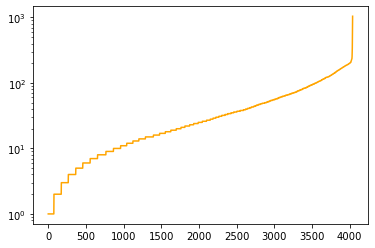

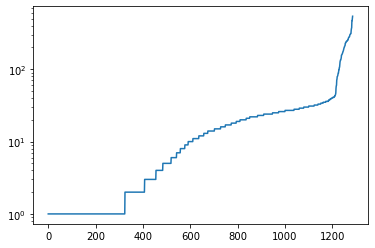

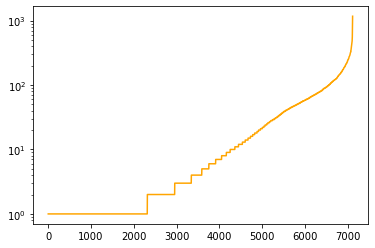

1 1167


In [12]:
def deg_list(G):
    L = []
    for N in G.Nodes():
        L.append(N.GetDeg())
    L.sort()
    return L

def find_N(L,d):
    a = 0
    b = len(L)
    while True:
        N = (a+b)//2
        if L[N]<=d and L[N+1]>d:
            return len(L)-N+1
        elif L[N]>d:
            b = N-1
        else: a = N+1

            
def find_N_d(L,X):
    D = L[-1]
    d = 0
    N = 0
    score = np.inf
    while d<len(L):
        d+=1
        N = find_N(L,d)
        s = N*X + d*D
        if s > score:
            d = d-1
            N = find_N(L,d)
            return d,N,score
        score = s

def find_X(L):
    D = L[-1]
    for X in range(D):
        d,N,score = find_N_d(L,X)
        if score<=X*X:
            return D,X,N,d
        
def find_Nd(L):
        d,N,_ = find_N_d(L,1,1)
        return d,N
    
G5 = snap.LoadEdgeList(snap.TUNGraph, "facebook_combined.txt", 0, 1)
#G1 = snap.GenRMat(4039, 88234, 0.6, 0.1, 0.15)
G1 = snap.LoadEdgeList(snap.TUNGraph, "lastfm4.txt", 0, 1)
N_G = G5.GetNodes()
n = N_G
v5 = 0.006158623641304036
alpha5 = 0.85*v5
Deg5 = np.array(deg_list(G5))
Deg1 = np.array(deg_list(G1))
X5 = [i for i in range(N_G)]
N_1 = len(Deg1)
X1 = [i for i in range(N_1)]
_, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(X5,Deg5,color = 'orange')
plt.show()
_, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(X1,Deg1)
plt.show()
L5,D5 = [i for i in range(N_G)],[i for i in range(N_G)]
L1,D1 = [i for i in range(N_1)],[i for i in range(N_1)]
G3 = snap.LoadEdgeList(snap.TNGraph, "Wiki-Vote.txt", 0, 1)
Deg3 = np.array(deg_list(G3))
v3 = 0.022150996701210627
alpha3 = 0.85*v3
N_3 = len(deg_list(G3))
X3 = [i for i in range(N_3)]
_, ax = plt.subplots()
ax.set_yscale('log')
plt.plot(X3,Deg3,color = 'orange')
plt.show()
L3,D3 = node_convertor(G3)
print(min(Deg3),max(Deg3))

# Creating randomized graphs

In [13]:
def create_copy(G,t):
    if t=='TUN':
        Gp = snap.TUNGraph.New()
    if t=='TN':
        Gp = snap.TNGraph.New()
    for NI in G.Nodes():
        Gp.AddNode(NI.GetId())
    for EI in G.Edges():
        Gp.AddEdge(EI.GetSrcNId(), EI.GetDstNId())
    return Gp

def create_random_TN(G,eps=1):
    p = 1/(1+np.exp(eps))
    Gp = snap.TNGraph.New()
    for NI in G.Nodes():
        Gp.AddNode(NI.GetId())
    for NI in G.Nodes():
        for N2 in G.Nodes():
            if rd.random()<p:
                Gp.AddEdge(NI.GetId(),N2.GetId())
    for EI in G.Edges():
        Gp.AddEdge(EI.GetSrcNId(), EI.GetDstNId())
        if rd.random()<p:
            Gp.DelEdge(EI.GetSrcNId(), EI.GetDstNId())
    return Gp

def create_random_TUN(G,L,eps=1):
    p = 1/(1+np.exp(eps))
    n = len(list(G.Nodes()))
    visited = np.zeros((n,n))
    visited2 = np.zeros((n,n))
    Gp = snap.TNGraph.New()
    for NI in G.Nodes():
        Gp.AddNode(NI.GetId())
    for NI in G.Nodes():
        for N2 in G.Nodes():
            if not(visited[L[NI.GetId()],L[N2.GetId()]]):
                visited[L[NI.GetId()],L[N2.GetId()]]=1
                visited[L[N2.GetId()],L[NI.GetId()]]=1
                if rd.random()<p:
                    Gp.AddEdge(NI.GetId(),N2.GetId())
    for EI in G.Edges():
        if not(visited2[L[EI.GetSrcNId()], L[EI.GetDstNId()]]):
            visited2[L[EI.GetSrcNId()], L[EI.GetDstNId()]]=1
            visited2[L[EI.GetDstNId()], L[EI.GetSrcNId()]]=1
            Gp.AddEdge(EI.GetSrcNId(), EI.GetDstNId())
            if rd.random()<p:
                Gp.DelEdge(EI.GetSrcNId(), EI.GetDstNId())
                Gp.DelEdge(EI.GetDstNId(), EI.GetSrcNId())
    return Gp

#Gp5 = create_random_TUN(G5,1)
#print(Gp5.GetEdges())
#Gp5 = create_random_TUN(G5,2)
#print(Gp5.GetEdges())


# Plotting for comparing optimal clipping to suboptimal clipping

In [15]:
def plot_clipping_step(G,D,L,alpha,X,STEP,ite=60,n_big=10,eps=1):  ### changing the number of steps
    n = len(list(G.Nodes()))
    S = len(STEP)
    E1 = [0]*S
    E2 = [0]*S
    B1 = [0]*S
    B2 = [0]*S
    R1 = [0]*S
    R2 = [0]*S
    F1 = [0]*S
    F2 = [0]*S
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    for _ in range(ite):
        for i in range(S):
            f1=0
            f2=0
        
            r_1 = katz_clipping_opt(G,D,L,X,alpha,STEP[i],n,eps)
            r_2 = katz_clipping_local(G,D,L,X,alpha,STEP[i],n,eps)
        
            e1,b1,r1 = loss_bias_error(r_k,r_1,n)
            e2,b2,r2 = loss_bias_error(r_k,r_2,n)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_2[i][1] for i in range(n_big)]
        
            for m in M_R:
                if m in M1:
                    f1+=1
                if m in M2:
                    f2+=1
        
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            B1[i]+=b1/ite
            B2[i]+=b2/ite
            R1[i]+=r1/ite
            R2[i]+=r2/ite
            F1[i]+=f1/(n_big*ite)
            F2[i]+=f2/(n_big*ite)
        
    , ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(STEP,E1,label = 'loss_opt')
    plt.plot(STEP,E2,label = 'loss_local')
    plt.plot(STEP,B1,label = "bias_opt")
    plt.plot(STEP,B2,label = "bias_local")
    plt.legend(loc = 'upper right')
    plt.show()
    plt.clf()

    if False:

        , ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(X,R1,label = 'err_opt')
        plt.plot(X,R2,label = 'err_local')
        plt.legend(loc = 'lower right')
        plt.show()
        plt.clf()
    
    , ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(STEP,F1,label = 'freq_opt')
    plt.plot(STEP,F2,label = 'freq_local')
    plt.legend(loc = 'lower right')
    plt.show()
    plt.clf()
    
def plot_clipping_X(G,D,L,alpha,X,STEP,ite=60,n_big=10,eps=1): ### changing the value of clipping
    n = len(list(G.Nodes()))
    S = len(X)
    E1 = [0]*S
    E2 = [0]*S
    B1 = [0]*S
    B2 = [0]*S
    R1 = [0]*S
    R2 = [0]*S
    F1 = [0]*S
    F2 = [0]*S
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    for _ in range(ite):
        for i in range(S):
            f1=0
            f2=0
        
            r_1 = katz_clipping_opt(G,D,L,X[i],alpha,STEP,n,eps)
            r_2 = katz_clipping_local(G,D,L,X[i],alpha,STEP,n,eps)
        
            e1,b1,r1 = loss_bias_error(r_k,r_1,n)
            e2,b2,r2 = loss_bias_error(r_k,r_2,n)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_2[i][1] for i in range(n_big)]
        
            for m in M_R:
                if m in M1:
                    f1+=1
                if m in M2:
                    f2+=1
        
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            B1[i]+=b1/ite
            B2[i]+=b2/ite
            R1[i]+=r1/ite
            R2[i]+=r2/ite
            F1[i]+=f1/(n_big*ite)
            F2[i]+=f2/(n_big*ite)
        
    , ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(X,E1,label = 'loss_opt')
    plt.plot(X,E2,label = 'loss_local')
    plt.plot(X,B1,label = "bias_opt")
    plt.plot(X,B2,label = "bias_local")
    plt.legend(loc = 'upper right')
    plt.show()
    plt.clf()
    
    if False:

        , ax = plt.subplots()
        ax.set_yscale('log')
        plt.plot(X,R1,label = 'err_opt')
        plt.plot(X,R2,label = 'err_local')
        plt.legend(loc = 'lower right')
        plt.show()
        plt.clf()
    
    , ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(X,F1,label = 'freq_opt')
    plt.plot(X,F2,label = 'freq_local')
    plt.legend(loc = 'lower right')
    plt.show()
    plt.clf()

# Comparing clipping to no clipping for number of paths (should be called walks)

In [16]:
def plot_path(G,D,L,X,STEP,ite=10,eps=1):
    n = len(list(G.Nodes()))
    S = len(STEP)
    STORE1 = np.zeros((S,n,ite))
    L1 = [0]*S
    L2 = [0]*S
    for i in trange(S):
        p_k = count_path(G,D,L,STEP[i],n)
        for j in range(ite):
            p_1 = count_path_clipping(G,D,L,X,STEP[i],n,eps)
            p_2 = count_path_noise(G,D,L,STEP[i],n,eps)
            
            for k in range(n):
                STORE1[i,k,j]=p_1[k]
                
            l1,_,_ = loss_bias_error(p_k,p_1,n)
            l2,_,_ = loss_bias_error(p_k,p_2,n)
            
            L1[i]+=l1/ite
            L2[i]+=l2/ite
    
    var1 = [0]*S
    for i in range(S):
        for k in range(n):
            var1[i]+=np.var(STORE1[i,k,:])/n

    B = [L1[i]-var1[i] for i in range(S)]
    
            
    #plt.plot(STEP,B,color='g')
    plt.plot(STEP,L1,'--s',color='b',label='loss_clipping')
    #plt.plot(STEP,var1,'--o',color='b',label='var_clipping')
    plt.plot(STEP,L2,'--s',color='orange',label='loss_no_clippping')
    #plt.plot(STEP,var2,'--o',color='orange',label='var_no_clipping')
    plt.yscale('log')
    plt.xlabel('Number of steps (S)')
    plt.ylabel('Loss')
    #plt.xticks(STEP)
    plt.legend(loc="upper left")
    #plt.show()
    plt.savefig("path10_facebook.png",dpi=300)
    return L1,L2

# Comparing the randomized to the clipping method (number of steps and size of subgraph)

In [19]:
def plot_size(G,SIZE,alpha,X,EPS,graph_type='TUN',ite=10,n_big=10): ### varying the size of the subgraph
    n = len(list(G.Nodes()))
    S = len(SIZE)
    print(EPS)
    store1 = np.zeros((S,ite))
    store2 = np.zeros((S,ite))
    store3 = np.zeros((S,ite))
    store4 = np.zeros((S,ite))
    VAR1 = [0]*S
    VAR2 = [0]*S
    
    F1 = [0]*S
    F2 = [0]*S
    F3 = [0]*S
    F4 = [0]*S
    L1 = [0]*S
    L2 = [0]*S
    E1 = [0]*S
    E2 = [0]*S
    #F3 = [0]*S
    #F4 = [0]*S
    #F5 = [0]*S

    
    for i in trange(S):
        
        n = SIZE[i]         
        
        STORE1 = np.zeros((n,ite))
        STORE2 = np.zeros((n,ite))
        
        
        for j in trange(ite):
            
            G1 = make_subgraph2(G,n)
            N = len(list(G1.Nodes()))
            L,D = node_convertor(G1)
        
            r_k = katz_by_graph_exploration(G1,D,L,alpha,80,N)
            R_K = [(r_k[i],i) for i in range(N)]
            R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
            M_R = [R_K[i][1] for i in range(n_big)]
            M_100 = [R_K[i][1] for i in range(100)]
                
            f1=0
            f2=0
            f3=0
            f4=0
            #f5=0
            
            r_1 = katz_clipping_opt(G1,D,L,X,alpha,10,N,EPS)
            
            if graph_type=='TUN':
                Gp = create_random_TUN(G1,D,EPS)
            if graph_type=='TN':
                Gp = create_random_TN(G1,EPS)
            r_2 = katz_by_graph_exploration(Gp,D,L,alpha,40,N)
            
            #r_2 = katz_clipping_opt(G,D,L,np.inf,alpha,1,n,EPS[i])
            
            for k in range(n):
                STORE1[k,j]=r_1[k]
                STORE2[k,j]=r_2[k]
            
            
            l1,_,e1 = loss_bias_error(r_k,r_1,n)
            l2,_,e2 = loss_bias_error(r_k,r_2,n)
            
            
            #r_3 = katz_by_clipping_noise(G,D,L,X,alpha,STEP[i],i,n_big*eps)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
            #R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
            #R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_1[i][1] for i in range(100)]
            M3 = [R_2[i][1] for i in range(n_big)]
            M4 = [R_2[i][1] for i in range(100)]
            
            
        
            for m in M_R:
                if m in M1:
                    f1+=0.1
                if m in M3:
                    f3+=0.1
            for m in M_100:
                if m in M2:
                    f2+=0.01
                if m in M4:
                    f4+=0.01
        
            F1[i]+=f1/ite
            F2[i]+=f2/ite
            F3[i]+=f3/ite
            F4[i]+=f4/ite
            L1[i]+=l1/ite
            L2[i]+=l2/ite
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            
            store1[i,j] = f1
            store2[i,j] = f2
            store3[i,j] = f3
            store4[i,j] = f4
            
        for k in range(n):
            VAR1[i]+=np.var(STORE1[k,:])/n
            VAR2[i]+=np.var(STORE2[k,:])/n
        
            
    var1 = []
    var2 = []
    var3 = []
    var4 = []
    for i in range(S):
        var1.append(np.sqrt(np.var(store1[i,:])/ite))
        var2.append(np.sqrt(np.var(store2[i,:])/ite))
        var3.append(np.sqrt(np.var(store3[i,:])/ite))
        var4.append(np.sqrt(np.var(store4[i,:])/ite))
    
    , ax = plt.subplots()
    plt.plot(SIZE,F1,'s',color='b',label = 'top10_clipping',linestyle='dashed')
    plt.errorbar(SIZE,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(SIZE,F2,'s',color='orange',label = 'top100_clipping',linestyle='dashed')
    plt.errorbar(SIZE,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
    plt.plot(SIZE,F3,'o',color='b',label = 'top10_randomized',linestyle='dashed')
    plt.errorbar(SIZE,F3,var3,capsize=10, fmt='o', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(SIZE,F4,'o',color='orange',label = 'top100_randomized',linestyle='dashed')
    plt.errorbar(SIZE,F4,var4,capsize=10, fmt='o', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(STEP,F3,label = 'exp2')
    #plt.plot(STEP,F5,label = 'freq_global')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Frequency of detection of top k nodes')
    plt.legend(loc = 'lower left',ncol=2)
    #plt.show()
    plt.savefig("detection_facebook_by_nodes.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(SIZE,L1,'--s',label = 'loss_clipping',color='b')
    plt.plot(SIZE,VAR1,'--o',label = 'var_clipping',color='b')
    plt.plot(SIZE,L2,'--s',label = 'loss_randomized',color='orange')
    plt.plot(SIZE,VAR2,'--o',label = 'var_randomized',color='orange')
    plt.xlabel('Number of Nodes')
    plt.ylabel('Loss and Variance')
    plt.yscale('log')
    #plt.xticks(STEP)
    plt.legend(loc = 'upper left',ncol=2)
    #plt.show()
    plt.savefig("loss_facebook_by_nodes.png",dpi=300)
    plt.clf()
    
    #, ax = plt.subplots()
    #plt.plot(STEP,E1,'--s',label = 'error_clipping')
    #plt.plot(STEP,E2,'--s',label = 'error_no_clipping')
    #plt.legend(loc = 'upper left')
    #plt.show()
    #plt.clf()
    
    return F1,F2,F3,F4

def plot_radomized_step(G,D,L,alpha,X,STEP,graph_type='TUN',ite=60,n_big=10,eps=1): ### varying the number of steps
    n = len(list(G.Nodes()))
    S = len(STEP)
    store1 = np.zeros((S,ite))
    store2 = np.zeros((S,ite))
    store3 = np.zeros((S,ite))
    store4 = np.zeros((S,ite))
    STORE1 = np.zeros((S,n,ite))
    STORE2 = np.zeros((S,n,ite))
    
    F1 = [0]*S
    F2 = [0]*S
    F3 = [0]*S
    F4 = [0]*S
    L1 = [0]*S
    L2 = [0]*S
    E1 = [0]*S
    E2 = [0]*S
    #F3 = [0]*S
    #F4 = [0]*S
    #F5 = [0]*S
    
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    M_100 = [R_K[i][1] for i in range(100)]
    
    for j in trange(ite):
        for i in range(S):
            f1=0
            f2=0
            f3=0
            f4=0
            #f5=0
        
            r_1 = katz_clipping_opt(G,D,L,X,alpha,STEP[i],n,eps)
            
            if graph_type=='TUN':
                Gp = create_random_TUN(G,D,eps)
            if graph_type=='TN':
                Gp = create_random_TN(G,eps)
            r_2 = katz_by_graph_exploration(Gp,D,L,alpha,STEP[i],n)
            
            for k in range(n):
                STORE1[i,k,j]=r_1[k]
                STORE2[i,k,j]=r_2[k]
            
            
            l1,_,e1 = loss_bias_error(r_k,r_1,n)
            l2,_,e2 = loss_bias_error(r_k,r_2,n)
            
            
            #r_3 = katz_by_clipping_noise(G,D,L,X,alpha,STEP[i],i,n_big*eps)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
            #R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
            #R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_1[i][1] for i in range(100)]
            M3 = [R_2[i][1] for i in range(n_big)]
            M4 = [R_2[i][1] for i in range(100)]
            
            
        
            for m in M_R:
                if m in M1:
                    f1+=0.1
                if m in M3:
                    f3+=0.1
            for m in M_100:
                if m in M2:
                    f2+=0.01
                if m in M4:
                    f4+=0.01
        
            F1[i]+=f1/ite
            F2[i]+=f2/ite
            F3[i]+=f3/ite
            F4[i]+=f4/ite
            L1[i]+=l1/ite
            L2[i]+=l2/ite
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            
            store1[i,j] = f1
            store2[i,j] = f2
            store3[i,j] = f3
            store4[i,j] = f4
            
    var1 = []
    var2 = []
    var3 = []
    var4 = []
    for i in range(S):
        var1.append(np.sqrt(np.var(store1[i,:])/ite))
        var2.append(np.sqrt(np.var(store2[i,:])/ite))
        var3.append(np.sqrt(np.var(store3[i,:])/ite))
        var4.append(np.sqrt(np.var(store4[i,:])/ite))
        
    VAR1 = [0]*S
    VAR2 = [0]*S
    for i in range(S):
        for k in range(n):
            VAR1[i]+=np.var(STORE1[i,k,:])/n
            VAR2[i]+=np.var(STORE2[i,k,:])/n
    
    , ax = plt.subplots()
    plt.plot(STEP,F1,'s',color='b',label = 'top10_clipping',linestyle='dashed')
    plt.errorbar(STEP,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(STEP,F2,'s',color='orange',label = 'top100_clipping',linestyle='dashed')
    plt.errorbar(STEP,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
    plt.plot(STEP,F3,'o',color='b',label = 'top10_randomized',linestyle='dashed')
    plt.errorbar(STEP,F3,var3,capsize=10, fmt='o', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(STEP,F4,'o',color='orange',label = 'top100_randomized',linestyle='dashed')
    plt.errorbar(STEP,F4,var4,capsize=10, fmt='o', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(STEP,F3,label = 'exp2')
    #plt.plot(STEP,F5,label = 'freq_global')
    plt.xlabel('Number of steps (S)')
    plt.ylabel('Frequency of detection of top k nodes')
    plt.legend(loc = 'lower left',ncol=2)
    #plt.show()
    plt.savefig("detection_wiki_randomized.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(STEP,L1,'--s',label = 'loss_clipping',color='b')
    plt.plot(STEP,VAR1,'--o',label = 'var_clipping',color='b')
    plt.plot(STEP,L2,'--s',label = 'loss_randomized',color='orange')
    plt.plot(STEP,VAR2,'--o',label = 'var_randomized',color='orange')
    plt.xlabel('Number of steps (S)')
    plt.ylabel('Loss and Variance')
    plt.yscale('log')
    #plt.xticks(STEP)
    plt.legend(loc = 'lower right',ncol=2)
    #plt.show()
    plt.savefig("loss_wiki_randomized.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(STEP,E1,'--s',label = 'error_clipping')
    plt.plot(STEP,E2,'--s',label = 'error_no_clipping')
    plt.legend(loc = 'upper left')
    plt.show()
    plt.clf()
    
    return F1,F2,F3,F4

In [23]:
SIZE = [800*i for i in range(1,6)]
F1,F2,F3,F4 = plot_size(G5,SIZE,alpha5,1/alpha5,2,graph_type='TUN',ite=40,n_big=10)

2


<Figure size 432x288 with 0 Axes>

In [20]:
SIZE = [800*i for i in range(1,6)]
F1,F2,F3,F4 = plot_size(G5,SIZE,alpha5,1/alpha5,2,graph_type='TUN',ite=3,n_big=10)

2


<Figure size 432x288 with 0 Axes>

# Still comparing the randomized algorithm to the clipping one varying the privacy budget (and other comparisons involving suboptimal clipping value)

In [10]:
def plot_compare(G,D,L,alpha,X,EPS,graph_type='TUN',ite=60,n_big=10):  ### varying the value of privacy budget
    n = len(list(G.Nodes()))
    S = len(EPS)
    store1 = np.zeros((S,ite))
    store2 = np.zeros((S,ite))
    store3 = np.zeros((S,ite))
    store4 = np.zeros((S,ite))
    STORE1 = np.zeros((S,n,ite))
    STORE2 = np.zeros((S,n,ite))
    
    F1 = [0]*S
    F2 = [0]*S
    F3 = [0]*S
    F4 = [0]*S
    L1 = [0]*S
    L2 = [0]*S
    E1 = [0]*S
    E2 = [0]*S
    #F3 = [0]*S
    #F4 = [0]*S
    #F5 = [0]*S
    
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    M_100 = [R_K[i][1] for i in range(100)]
    
    for i in trange(S):
        for j in trange(ite):
            f1=0
            f2=0
            f3=0
            f4=0
            #f5=0
            
            r_1 = katz_clipping_opt(G,D,L,X,alpha,10,n,EPS[i])
            
            if graph_type=='TUN':
                Gp = create_random_TUN(G,EPS[i])
            if graph_type=='TN':
                Gp = create_random_TN(G,EPS[i])
            r_2 = katz_by_graph_exploration(Gp,D,L,alpha,40,n)
            
            #r_2 = katz_clipping_opt(G,D,L,np.inf,alpha,1,n,EPS[i])
            
            for k in range(n):
                STORE1[i,k,j]=r_1[k]
                STORE2[i,k,j]=r_2[k]
            
            
            l1,_,e1 = loss_bias_error(r_k,r_1,n)
            l2,_,e2 = loss_bias_error(r_k,r_2,n)
            
            
            #r_3 = katz_by_clipping_noise(G,D,L,X,alpha,STEP[i],i,n_big*eps)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
            #R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
            #R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_1[i][1] for i in range(100)]
            M3 = [R_2[i][1] for i in range(n_big)]
            M4 = [R_2[i][1] for i in range(100)]
            
            
        
            for m in M_R:
                if m in M1:
                    f1+=0.1
                if m in M3:
                    f3+=0.1
            for m in M_100:
                if m in M2:
                    f2+=0.01
                if m in M4:
                    f4+=0.01
        
            F1[i]+=f1/ite
            F2[i]+=f2/ite
            F3[i]+=f3/ite
            F4[i]+=f4/ite
            L1[i]+=l1/ite
            L2[i]+=l2/ite
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            
            store1[i,j] = f1
            store2[i,j] = f2
            store3[i,j] = f3
            store4[i,j] = f4
            
    var1 = []
    var2 = []
    var3 = []
    var4 = []
    for i in range(S):
        var1.append(np.sqrt(np.var(store1[i,:])/ite))
        var2.append(np.sqrt(np.var(store2[i,:])/ite))
        var3.append(np.sqrt(np.var(store3[i,:])/ite))
        var4.append(np.sqrt(np.var(store4[i,:])/ite))
        
    VAR1 = [0]*S
    VAR2 = [0]*S
    for i in range(S):
        for k in range(n):
            VAR1[i]+=np.var(STORE1[i,k,:])/n
            VAR2[i]+=np.var(STORE2[i,k,:])/n
    
    , ax = plt.subplots()
    plt.plot(EPS,F1,'s',color='b',label = 'top10_clipping',linestyle='dashed')
    plt.errorbar(EPS,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(EPS,F2,'s',color='orange',label = 'top100_clipping',linestyle='dashed')
    plt.errorbar(EPS,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
    plt.plot(EPS,F3,'o',color='b',label = 'top10_randomized',linestyle='dashed')
    plt.errorbar(EPS,F3,var3,capsize=10, fmt='o', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(EPS,F4,'o',color='orange',label = 'top100_randomized',linestyle='dashed')
    plt.errorbar(EPS,F4,var4,capsize=10, fmt='o', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(STEP,F3,label = 'exp2')
    #plt.plot(STEP,F5,label = 'freq_global')
    plt.xlabel('Epsilon')
    plt.ylabel('Frequency of detection of top k nodes')
    plt.legend(loc = 'lower left',ncol=2)
    plt.show()
    #plt.savefig("detection_vs_randomized_wiki_bis.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(EPS,L1,'--s',label = 'loss_clipping',color='b')
    plt.plot(EPS,VAR1,'--o',label = 'var_clipping',color='b')
    plt.plot(EPS,L2,'--s',label = 'loss_randomized',color='orange')
    plt.plot(EPS,VAR2,'--o',label = 'var_randomized',color='orange')
    plt.xlabel('Epsilon')
    plt.ylabel('Loss and Variance')
    plt.yscale('log')
    #plt.xticks(STEP)
    plt.legend(loc = 'upper left',ncol=2)
    plt.show()
    #plt.savefig("loss_vs_randomized_wiki_bis.png",dpi=300)
    plt.clf()
    
    #, ax = plt.subplots()
    #plt.plot(STEP,E1,'--s',label = 'error_clipping')
    #plt.plot(STEP,E2,'--s',label = 'error_no_clipping')
    #plt.legend(loc = 'upper left')
    #plt.show()
    #plt.clf()
    
    return F1,F2,L1,L2,VAR1,VAR2

def plot_clipping_step(G,D,L,alpha,X,STEP,ite=60,n_big=10,eps=1):  ### varying the number of steps (optimal clipping vs suboptimal)
    n = len(list(G.Nodes()))
    S = len(STEP)
    store1 = np.zeros((S,ite))
    store2 = np.zeros((S,ite))
    store3 = np.zeros((S,ite))
    store4 = np.zeros((S,ite))
    STORE1 = np.zeros((S,n,ite))
    STORE2 = np.zeros((S,n,ite))
    
    F1 = [0]*S
    F2 = [0]*S
    F3 = [0]*S
    F4 = [0]*S
    L1 = [0]*S
    L2 = [0]*S
    E1 = [0]*S
    E2 = [0]*S
    #F3 = [0]*S
    #F4 = [0]*S
    #F5 = [0]*S
    
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    M_100 = [R_K[i][1] for i in range(100)]
    
    for j in trange(ite):
        for i in range(S):
            f1=0
            f2=0
            f3=0
            f4=0
            #f5=0
        
            r_1 = katz_clipping_opt(G,D,L,X,alpha,STEP[i],n,eps)
            r_2 = katz_without_clipping(G,D,L,alpha,STEP[i],n,eps)
            for k in range(n):
                STORE1[i,k,j]=r_1[k]
                STORE2[i,k,j]=r_2[k]
            
            
            l1,_,e1 = loss_bias_error(r_k,r_1,n)
            l2,_,e2 = loss_bias_error(r_k,r_2,n)
            
            
            #r_3 = katz_by_clipping_noise(G,D,L,X,alpha,STEP[i],i,n_big*eps)
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            R_2 = [(r_2[i],i) for i in range(len(r_2))]
            #R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
            #R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_1[i][1] for i in range(100)]
            M3 = [R_2[i][1] for i in range(n_big)]
            M4 = [R_2[i][1] for i in range(100)]
            
            
        
            for m in M_R:
                if m in M1:
                    f1+=0.1
                if m in M3:
                    f3+=0.1
            for m in M_100:
                if m in M2:
                    f2+=0.01
                if m in M4:
                    f4+=0.01
        
            F1[i]+=f1/ite
            F2[i]+=f2/ite
            F3[i]+=f3/ite
            F4[i]+=f4/ite
            L1[i]+=l1/ite
            L2[i]+=l2/ite
            E1[i]+=e1/ite
            E2[i]+=e2/ite
            
            store1[i,j] = f1
            store2[i,j] = f2
            store3[i,j] = f3
            store4[i,j] = f4
            
    var1 = []
    var2 = []
    var3 = []
    var4 = []
    for i in range(S):
        var1.append(np.sqrt(np.var(store1[i,:])/ite))
        var2.append(np.sqrt(np.var(store2[i,:])/ite))
        var3.append(np.sqrt(np.var(store3[i,:])/ite))
        var4.append(np.sqrt(np.var(store4[i,:])/ite))
        
    VAR1 = [0]*S
    VAR2 = [0]*S
    for i in range(S):
        for k in range(n):
            VAR1[i]+=np.var(STORE1[i,k,:])/n
            VAR2[i]+=np.var(STORE2[i,k,:])/n
    
    , ax = plt.subplots()
    plt.plot(STEP,F1,'s',color='b',label = 'top10_clipping',linestyle='dashed')
    plt.errorbar(STEP,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(STEP,F2,'s',color='orange',label = 'top100_clipping',linestyle='dashed')
    plt.errorbar(STEP,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
    plt.plot(STEP,F3,'o',color='b',label = 'top10_no_clipping',linestyle='dashed')
    plt.errorbar(STEP,F3,var3,capsize=10, fmt='o', ecolor='black', markeredgecolor = "b", color='b')
    plt.plot(STEP,F4,'o',color='orange',label = 'top100_no_clipping',linestyle='dashed')
    plt.errorbar(STEP,F4,var4,capsize=10, fmt='o', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(STEP,F3,label = 'exp2')
    #plt.plot(STEP,F5,label = 'freq_global')
    plt.xlabel('Number of steps (S)')
    plt.ylabel('Frequency of detection of top k nodes')
    plt.legend(loc = 'lower left',ncol=2)
    plt.show()
    #plt.savefig("loss_step_wiki.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(STEP,L1,'--s',label = 'loss_clipping',color='b')
    plt.plot(STEP,VAR1,'--o',label = 'var_clipping',color='b')
    plt.plot(STEP,L2,'--s',label = 'loss_no_clipping',color='orange')
    plt.plot(STEP,VAR2,'--o',label = 'var_no_clipping',color='orange')
    plt.xlabel('Number of steps (S)')
    plt.ylabel('Loss and Variance')
    plt.yscale('log')
    #plt.xticks(STEP)
    plt.legend(loc = 'upper left',ncol=2)
    plt.show()
    #plt.savefig("detection_step_wiki.png",dpi=300)
    plt.clf()
    
    , ax = plt.subplots()
    plt.plot(STEP,E1,'--s',label = 'error_clipping')
    plt.plot(STEP,E2,'--s',label = 'error_no_clipping')
    plt.legend(loc = 'upper left')
    plt.show()
    plt.clf()
    
    return F1,F2
    
def plot_clipping_X(G,D,L,alpha,X,STEP,ite=60,n_big=10,eps=1): ### varying the value of clipping factor (only for the clipping algo)
    n = len(list(G.Nodes()))
    S = len(X)
    store1 = np.zeros((S,ite))
    store2 = np.zeros((S,ite))
    STORE = np.zeros((S,n,ite))
    
    F1 = [0]*S
    F2 = [0]*S
    L1 = [0]*S
    #F3 = [0]*S
    #F4 = [0]*S
    #F5 = [0]*S
    
    r_k = katz_by_graph_exploration(G,D,L,alpha,80,n)
    R_K = [(r_k[i],i) for i in range(n)]
    R_K = sorted(R_K,key = lambda l : l[0],reverse = True)
    M_R = [R_K[i][1] for i in range(n_big)]
    M_100 = [R_K[i][1] for i in range(100)]
    
    for j in trange(ite):
        for i in range(S):
            f1=0
            f2=0
            #f3=0
            #f4=0
            #f5=0
        
            r_1 = katz_clipping_opt(G,D,L,X[i],alpha,STEP,n,eps)
            #r_2 = katz_clipping_local(G,D,L,X[i],alpha,STEP,n,eps)
            #r_3 = katz_by_clipping_noise(G,D,L,X[i],alpha,STEP,n,n_big*eps)
            for k in range(n):
                STORE[i,k,j]=r_1[k]
            
        
            R_1 = [(r_1[i],i) for i in range(len(r_1))]
            #R_2 = [(r_2[i],i) for i in range(len(r_2))]
            #R_3 = [(r_3[i],i) for i in range(len(r_3))]
        
            R_1 = sorted(R_1,key=lambda l : l[0],reverse = True)
            #R_2 = sorted(R_2,key=lambda l : l[0],reverse = True)
            #R_3 = sorted(R_3,key=lambda l : l[0],reverse = True)
        
            M1 = [R_1[i][1] for i in range(n_big)]
            M2 = [R_1[i][1] for i in range(100)]
            #M2 = [R_2[i][1] for i in range(n_big)]
            #M5 = [R_3[i][1] for i in range(n_big)]
            
            #M2 = exponential(G,D,L,X[i],alpha,STEP,n_big,n,eps)
            #M3 = expo2(G,D,L,X[i],alpha,STEP,n_big,n,eps)
        
            for m in M_R:
                if m in M1:
                    f1+=0.1
            for m in M_100:
                if m in M2:
                    f2+=0.01
                    
            l,_,_ = loss_bias_error(r_k,r_1,n)
            L1[i]+=l/ite

            F1[i]+=f1/ite
            F2[i]+=f2/ite
            store1[i,j]=f1
            store2[i,j]=f2
            #F3[i]+=f3/(n_big*ite)
            #F4[i]+=f4/(n_big*ite)
            #F5[i]+=f5/(n_big*ite)
            
    var1 = []
    var2 = []
    for i in range(S):
        var1.append(np.sqrt(np.var(store1[i,:])/ite))
        var2.append(np.sqrt(np.var(store2[i,:])/ite))
        
    VAR = [0]*S
    for i in range(S):
        for k in range(n):
            VAR[i]+=np.var(STORE[i,k,:])/n
    
    , ax = plt.subplots()
    ax.set_yscale('log')
    plt.plot(X,F1,'s',color='b',label = 'top10',linestyle='dashed')
    plt.errorbar(X,F1,var1,capsize=10, fmt='s', ecolor='black', markeredgecolor = "b", color='b')
    #plt.plot(X,F2,label = 'freq_local')
    plt.plot(X,F2,'s',color='orange',label = 'top100',linestyle='dashed')
    plt.errorbar(X,F2,var2,capsize=10, fmt='s', ecolor='black', markeredgecolor = "orange", color='orange')
    #plt.plot(X,F3,label = 'freq_exp2')
    #plt.plot(X,F5,label = 'freq_global')
    plt.xlabel('Clipping factor (X)')
    plt.ylabel('Frequency of detection of top k nodes')
    plt.legend(loc = 'lower right')
    plt.savefig("detection_clipping_wiki.png",dpi=300)
    plt.clf()
    #print(store1)
    
    , ax = plt.subplots()
    plt.plot(X,L1,'--s',label = 'loss',color='b')
    plt.plot(X,VAR,'--o',label = 'variance',color='b')
    plt.xlabel('Clipping factor (X)')
    plt.ylabel('Loss and Variance')
    plt.legend(loc = 'upper right')
    plt.savefig("loss_clipping_wiki.png",dpi=300)
    plt.clf()


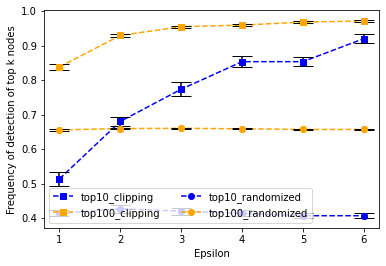

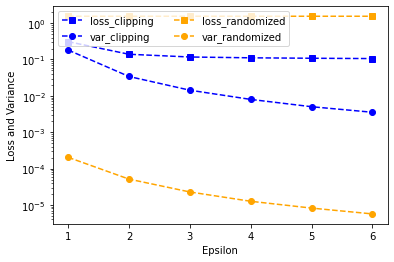

<Figure size 432x288 with 0 Axes>

In [51]:
EPS = [1,2,3,4,5,6]
F1,F2,L1,L2,VAR1,VAR2 = plot_compare(G5,D5,L5,alpha5,1/alpha5,EPS,graph_type='None',ite=15)

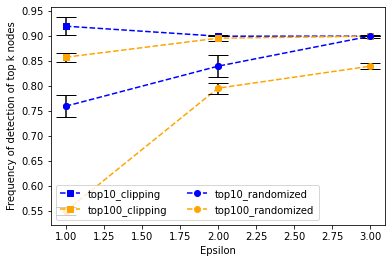

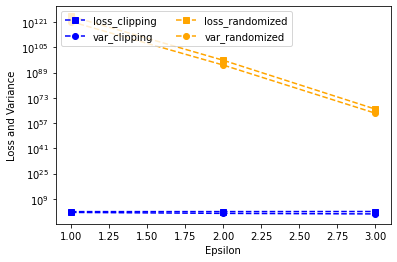

<Figure size 432x288 with 0 Axes>

In [10]:
EPS = [1,2,3]
F1,F2,L1,L2,VAR1,VAR2 = plot_compare(G3,D3,L3,alpha3,1/alpha3,EPS,graph_type='TN',ite=5)

In [12]:
print(F1)
print(F2)
print(L1)
print(L2)
print(VAR1)
print(VAR2)
print([L2[i]/VAR2[i] for i in range(3)])

[0.9199999999999999, 0.8999999999999999, 0.8999999999999999]
[0.8580000000000005, 0.8960000000000006, 0.9000000000000006]
[7.201222597478521, 7.4622623081432335, 8.501101237440961]
[4.788840975687383e+124, 6.194972254669073e+96, 6.77394065998011e+65]
[2.2657902868620994, 0.5576418906250586, 0.25175291565987207]
[1.869927228079236e+121, 5.8194761523736515e+93, 1.681609167844167e+63]
[2560.9771887253683, 1064.524038326416, 402.8249125606482]
